In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

import os

import helpers as h


import argparse
import logging

%load_ext autoreload
%autoreload 2

In [2]:
start = datetime(2020,3,1)
end = datetime(2023,5,12)

all_dates = h.get_dates(start, end)

features_ = pd.DataFrame(
    {'Date': all_dates},
)



In [11]:
ranges = pd.read_csv("bad_dates.csv", parse_dates=['start', 'end'])

bad_dates = h.get_forbidden_dates(ranges)

wb_features = features_[~features_['Date'].isin(bad_dates)]
bad_features = features_[features_['Date'].isin(bad_dates)]

In [3]:
ds_duration = 900
ds_period = 10
IBSorOBS = 'OBS'

profiles = h.in_sklearn_format(features_, ds_duration, ds_period, IBSorOBS, hp_folder = h.HP_FOLDER)

if ds_period < 0:
    HP_TIME_BINS = h.get_var_time_bins(ds_duration)
else:
    HP_TIME_BINS = np.arange(0, ds_duration, ds_period)

In [7]:
mag, phi, theta = h.cart2sph(profiles['R'].values,profiles['T'].values,profiles['N'].values)

profiles['phi'] = phi
profiles['theta'] = theta
profiles['|B|'] = mag

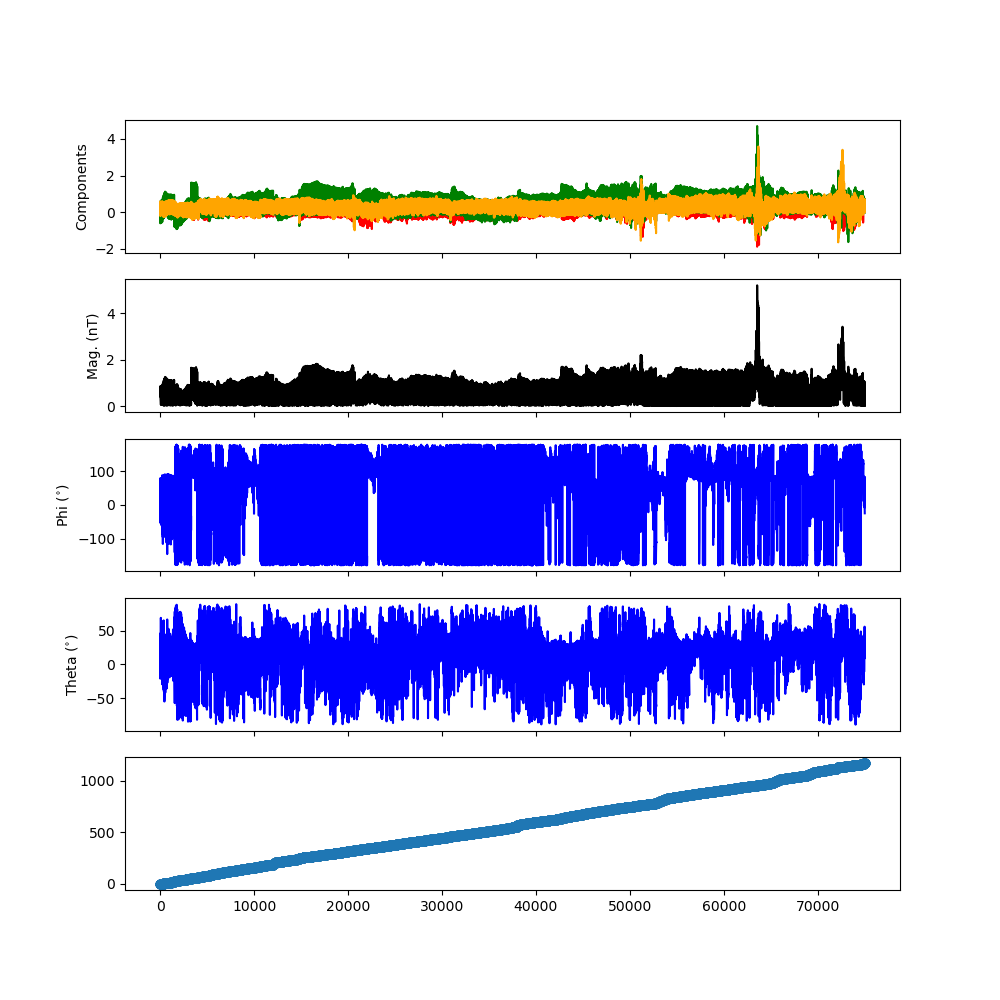

In [5]:
%matplotlib ipympl
fig, axs = plt.subplots(5, 1, sharex=True, figsize = (10,10))

axs[0].plot(profiles['R'], color = 'red')
axs[0].plot(profiles['T'], color = 'green')
axs[0].plot(profiles['N'], color = 'orange')
axs[0].set_ylabel('Components')

axs[1].plot(profiles['|B|'], color = 'black')
axs[1].set_ylabel('Mag. (nT)')

axs[2].plot(profiles['phi'], color = 'blue')
axs[2].set_ylabel(r'Phi ($^{\circ}$)')
axs[3].plot(profiles['theta'], color = 'blue')
axs[3].set_ylabel(r'Theta ($^{\circ}$)')

axs[4].plot(profiles['hp_id'], marker = 'o')

# Heatmap

In [12]:
N = features_.shape[0]

components = ['|B|', 'phi', 'theta']
first = np.ones((len(HP_TIME_BINS), N))*np.nan
second = np.ones((len(HP_TIME_BINS), N))*np.nan
third = np.ones((len(HP_TIME_BINS), N))*np.nan

for i in tqdm(features_.index):
    selected_day = profiles.loc[profiles['hp_id'] == i]
    
    
    if i not in bad_features.index:
        # if too short then pad with np.nan
        if selected_day.shape[0] < len(HP_TIME_BINS):
            first[:selected_day.shape[0], i] = selected_day[components[0]].values
            second[:selected_day.shape[0], i] = selected_day[components[1]].values
            third[:selected_day.shape[0], i] = selected_day[components[2]].values
        else:
            first[:, i] = selected_day[components[0]].values
            second[:, i] = selected_day[components[1]].values
            third[:, i] = selected_day[components[2]].values
    else:
        first[:, i] = np.nan
        second[:, i] = np.nan
        third[:, i] = np.nan



  0%|          | 0/1168 [00:00<?, ?it/s]

100%|██████████| 1168/1168 [00:00<00:00, 4000.53it/s]


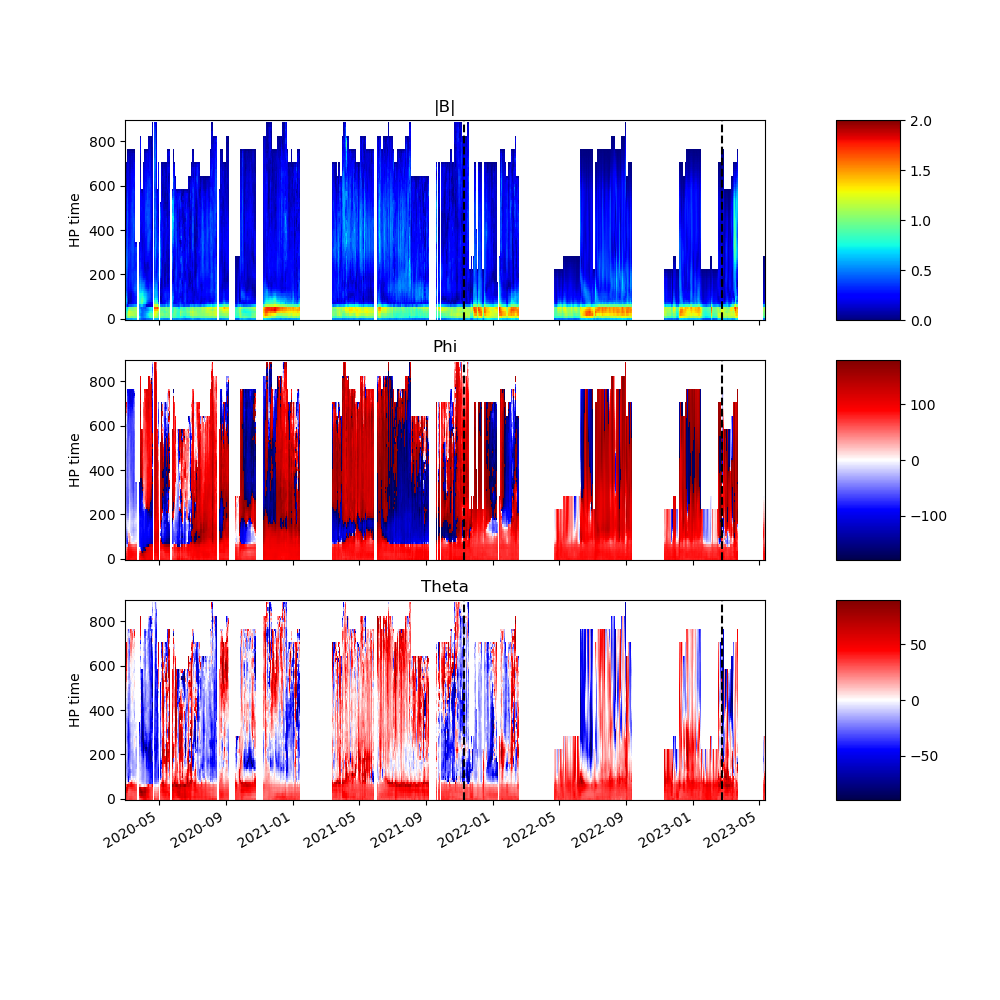

In [13]:
%matplotlib ipympl
fig = plt.figure(figsize=(10, 10))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(3, 2, width_ratios = [10,1])
# Create the Axes.
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0], sharex=ax0, sharey=ax0)
ax2 = fig.add_subplot(gs[2, 0], sharex=ax0, sharey=ax0)
cax0 = fig.add_subplot(gs[0, 1])
cax1 = fig.add_subplot(gs[1, 1])
cax2 = fig.add_subplot(gs[2, 1])


cmap = 'jet'

coord = 'sph'


if coord == 'sph':
    cb = ax0.pcolormesh(features_['Date'], HP_TIME_BINS,  first, cmap = cmap, vmax = 2, vmin = 0)
    plt.colorbar(cb, cax = cax0)
    
    cb = ax1.pcolormesh(features_['Date'], HP_TIME_BINS,  second, cmap = 'seismic', vmax = 180, vmin = -180)
    plt.colorbar(cb, cax = cax1)
    
    cb = ax2.pcolormesh(features_['Date'], HP_TIME_BINS,  third, cmap = 'seismic', vmax = 90, vmin = -90)
    plt.colorbar(cb, cax = cax2)



for ax in [ax0, ax1, ax2]:
    # ax.axvline(datetime(2022,12,31), color = 'black', ls = '--')
    
    ax.axvline(datetime(2023,2,23), color = 'black', ls = '--')
    
    ax.axvline(datetime(2021,11,8), color = 'black', ls = '--')

ax0.set_title('|B|')
ax1.set_title('Phi')
ax2.set_title('Theta')

ax0.set_ylabel('HP time')
ax1.set_ylabel('HP time')
ax2.set_ylabel('HP time')


fig.autofmt_xdate()

# Investigating individual profiles

Text(0, 0.5, 'Theta ($^{\\circ}$)')

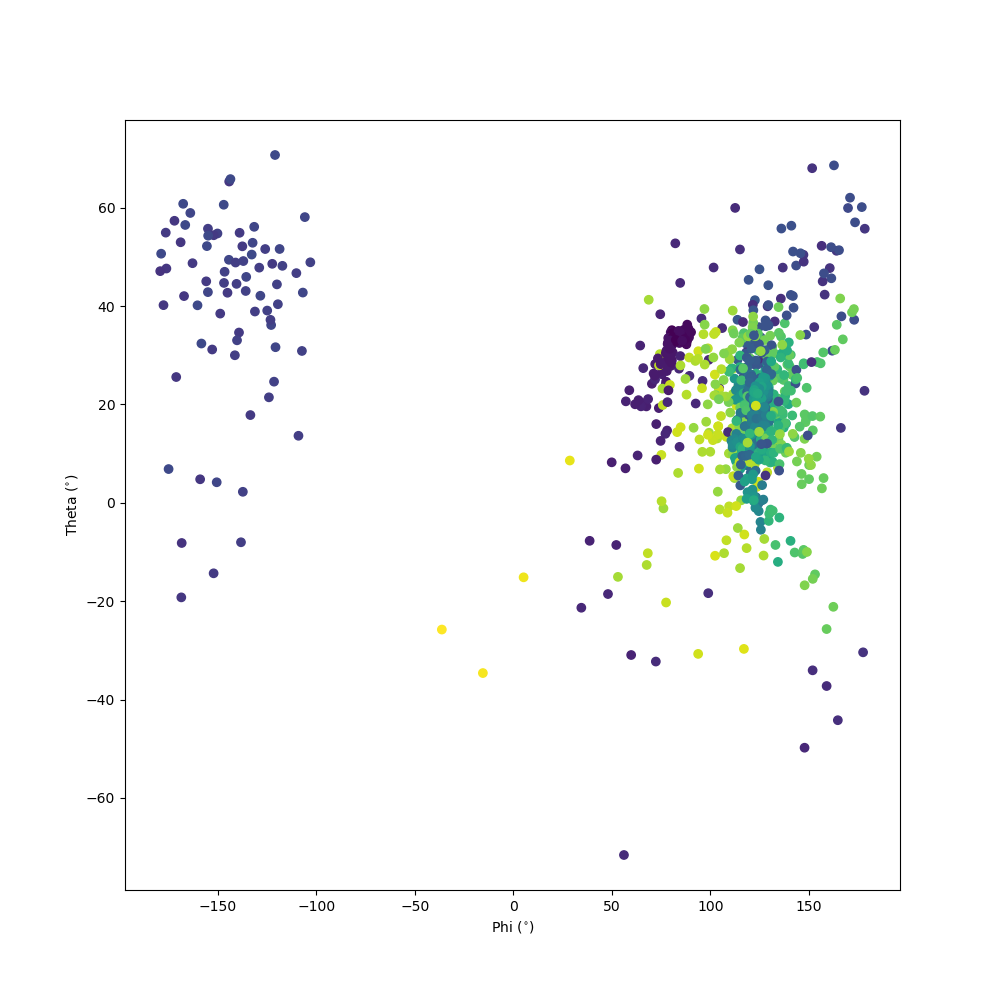

In [44]:
fig, axs = plt.subplots(1, 1, sharex=True, figsize = (10,10))
hp_id_low = 438
hp_id_high = 452

profiles_to_plot = profiles.loc[(profiles['hp_id'] > hp_id_low) & (profiles['hp_id'] < hp_id_high)]

axs.scatter(profiles_to_plot['phi'], profiles_to_plot['theta'], c= profiles_to_plot['Time']/ds_duration )
axs.set_xlabel(r'Phi ($^{\circ}$)')
axs.set_ylabel(r'Theta ($^{\circ}$)')

Text(0, 0.5, 'Theta ($^{\\circ}$)')

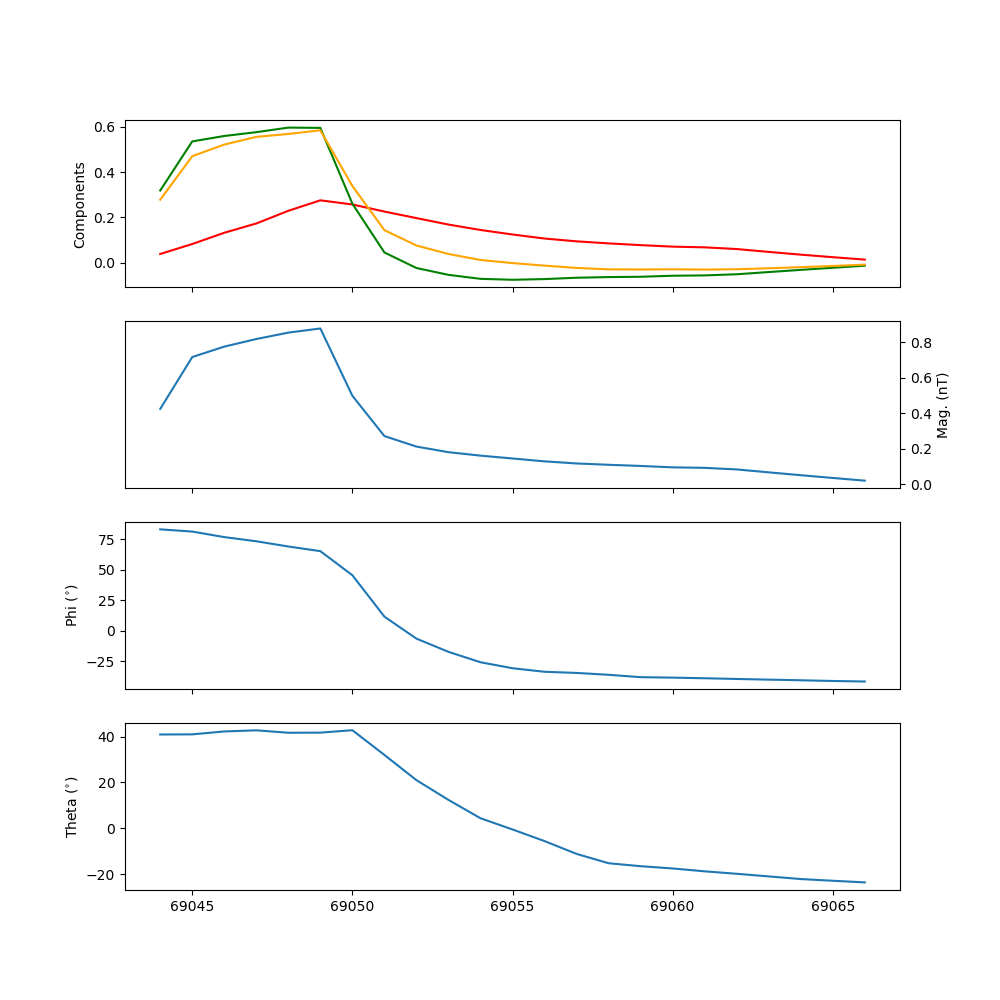

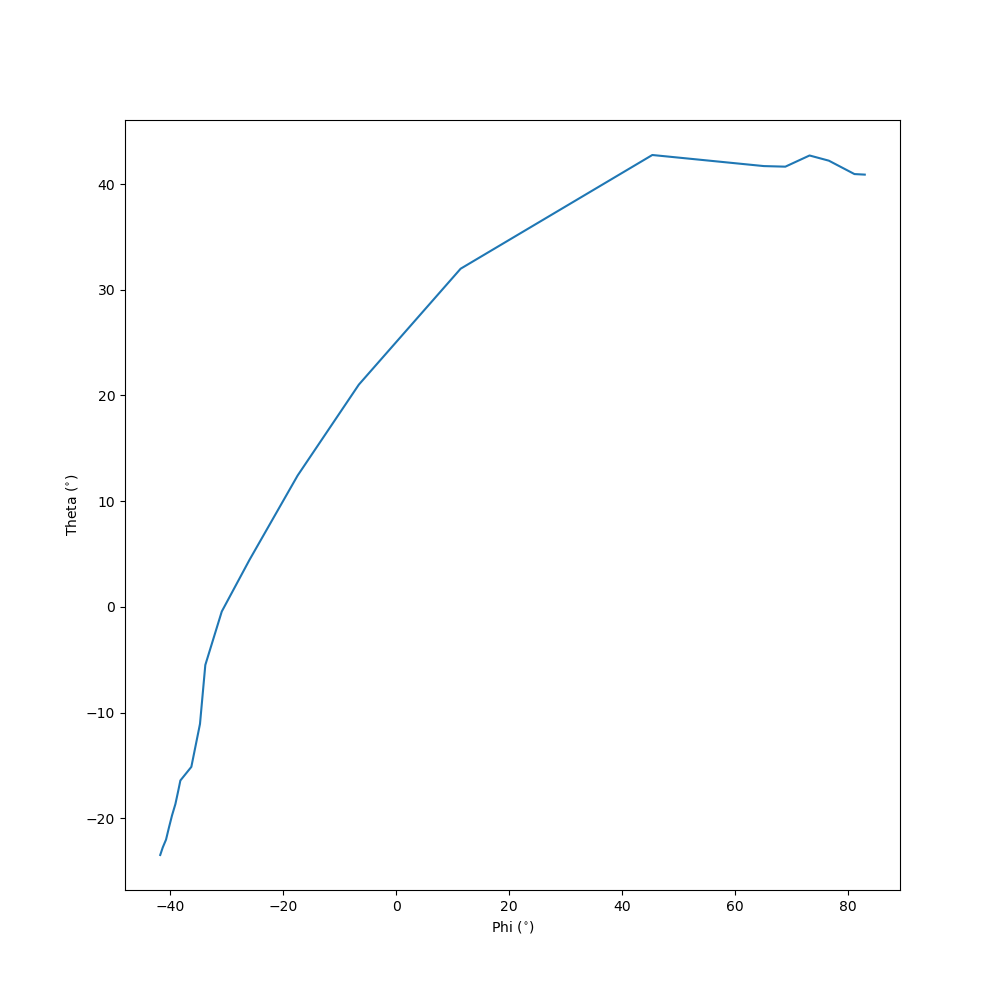

In [33]:
%matplotlib ipympl

hp_id = 1057

profile = profiles.loc[profiles['hp_id'] == hp_id]

fig, axs = plt.subplots(4, 1, sharex=True, figsize = (10,10))

axs[0].plot(profile['R'], color = 'red')
axs[0].plot(profile['T'], color = 'green')
axs[0].plot(profile['N'], color = 'orange')
axs[0].set_ylabel('Components')

axs[1].plot(profile['mag'])
axs[1].set_ylabel('Mag. (nT)')
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()

axs[2].plot(profile['phi'])
axs[2].set_ylabel(r'Phi ($^{\circ}$)')
axs[3].plot(profile['theta'])
axs[3].set_ylabel(r'Theta ($^{\circ}$)')


Text(0, 0.5, 'Theta ($^{\\circ}$)')

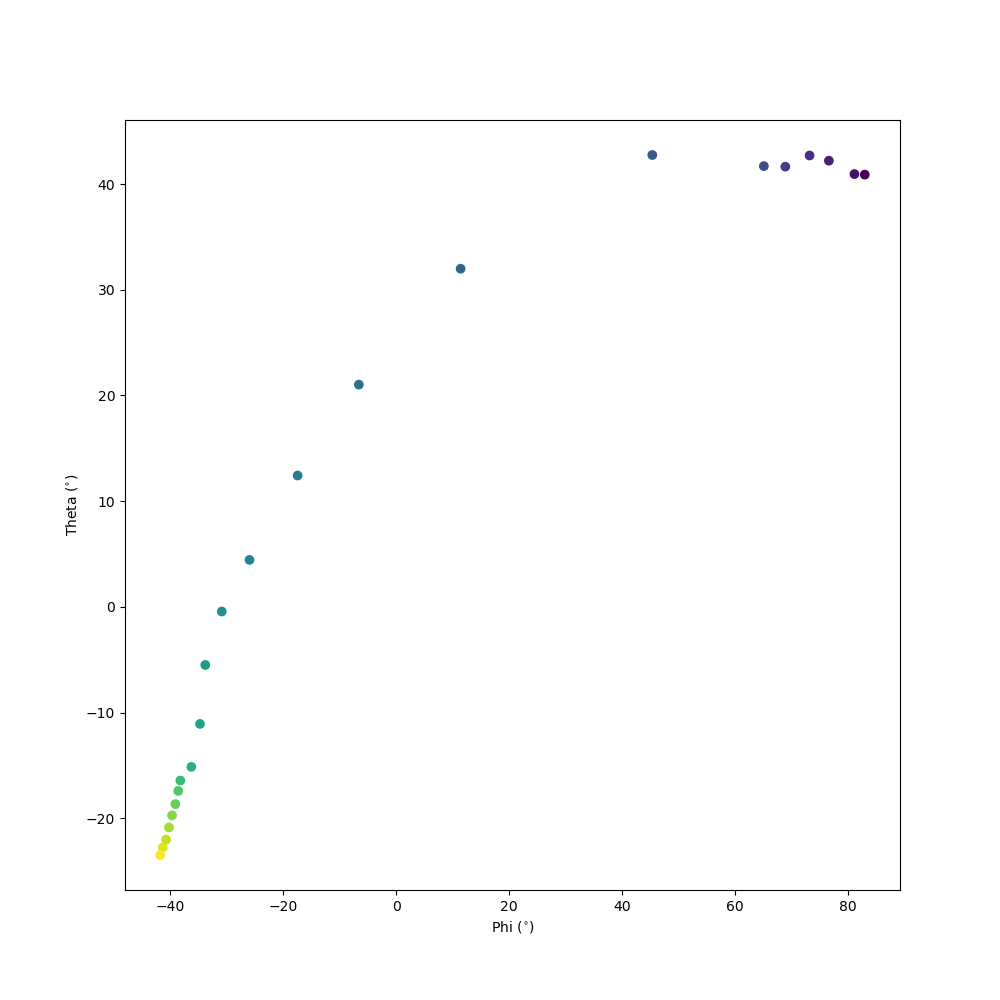

In [35]:
fig, axs = plt.subplots(1, 1, sharex=True, figsize = (10,10))
axs.scatter(profile['phi'], profile['theta'], c= np.linspace(0, 1, profile.shape[0]) )
axs.set_xlabel(r'Phi ($^{\circ}$)')
axs.set_ylabel(r'Theta ($^{\circ}$)')